# Hybrid GAN with CLIP text prompts
### Mateusz Cedro

### Hybrid model allowing to generate images from text input prompts 

In [1]:
# CLIP Contrastive Language-Image Pre-Training
!git clone https://github.com/openai/CLIP.git

# Taming-Transformers
!git clone https://github.com/CompVis/taming-transformers.git

Cloning into 'CLIP'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 251 (delta 3), reused 3 (delta 0), pack-reused 243
Receiving objects: 100% (251/251), 8.93 MiB | 25.11 MiB/s, done.
Resolving deltas: 100% (127/127), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1342 (delta 0), reused 1 (delta 0), pack-reused 1340
Receiving objects: 100% (1342/1342), 409.77 MiB | 34.77 MiB/s, done.
Resolving deltas: 100% (281/281), done.


In [2]:
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf pytorch-lightning
!pip uninstall torchtext
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 961.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 36.2 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=80ded8ff6a4886d8b92fd6bf7000cda4898846ef1738a6af67717a659d2096c7
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


Found existing installation: torchtext 0.16.0
Uninstalling torchtext-0.16.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/torchtext-0.16.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torchtext/*
Proceed (Y/n)? y
  Successfully uninstalled torchtext-0.16.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 814.6 kB/s eta 0:00:00


In [3]:
import numpy as np
import torch, os, imageio, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import yaml
from omegaconf import OmegaConf

from CLIP import clip

import warnings
warnings.filterwarnings('ignore')

In [4]:
def show_from_tensor(tensor):
  img = tensor.clone()
  img = img.mul(255).byte()
  img = img.cpu().numpy().transpose((1,2,0))

  plt.figure(figsize=(10,7))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

def norm_data(data):
  return (data.clip(-1,1)+1)/2 # normalization

In [72]:
# Hyperparameters
lr = 0.5
batch_size = 1
wd = 0.1 # weight decay
noise_factor = 0.1

total_iter = 300
im_shape = [225, 400, 3] # H, W, C
size1, size2, channels = im_shape

In [73]:
### CLIP MODEL

clipmodel, _ = clip.load('ViT-B/32', jit=False)
clipmodel.eval()
print(clip.available_models())

print("Clip model visual input resolution: ", clipmodel.visual.input_resolution)

device = torch.device("cuda:0")
torch.cuda.empty_cache()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip model visual input resolution:  224


In [74]:
# Taming transformer instantiation

%cd taming-transformers/

!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
  !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
  !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'


[Errno 2] No such file or directory: 'taming-transformers/'
/content/taming-transformers


/content/taming-transformers/taming/data/utils.py

'''python
string_classes=str
string_classes=str
'''

In [75]:
from taming.models.vqgan import VQModel

def load_config(config_path, display=False):
  config_data = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config_data)))
  return config_data

def load_vqgan(config, chk_path=None):
  model = VQModel(**config.model.params)
  if chk_path is not None:
    state_dict = torch.load(chk_path, map_location='cpu')['state_dict']
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
  return model.eval()

def generator(x):
  x = taming_model.post_quant_conv(x)
  x = taming_model.decoder(x)
  return x

taming_config = load_config("/content/taming-transformers/models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, chk_path='/content/taming-transformers/models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt').to(device)


model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [76]:
### Declare values to optimize

class Parameters(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.data = 0.5*torch.randn(batch_size, 256, size1//16, size2//16).cuda() # 1 x 256 x 14 x 25
    self.data = torch.nn.Parameter(torch.sin(self.data))

  def forward(self):
    return self.data


def init_params():
  params = Parameters().cuda()
  optimizer = torch.optim.AdamW([{'params':[params.data], 'lr': lr}], weight_decay=wd)
  return params, optimizer

torch.Size([1, 256, 14, 25])
img dimesnions:  torch.Size([1, 3, 224, 400])


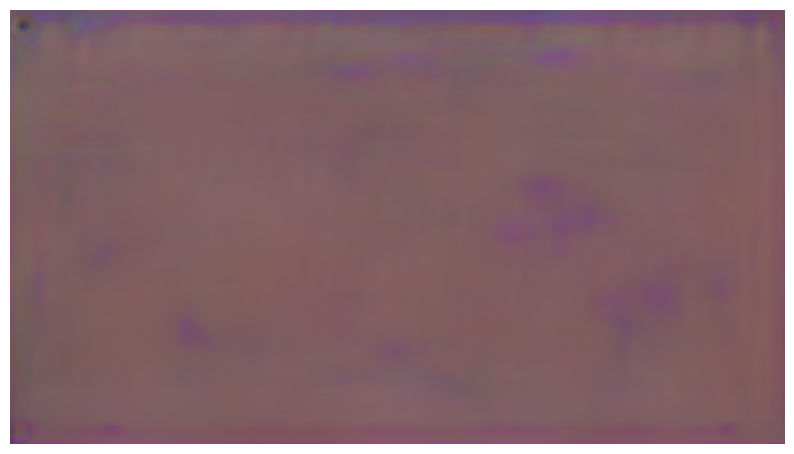

In [77]:
# Encoding prompts and a few more things

normalize = T.Normalize((0.48145466, 0.4578275, 0.040821073),
                        (0.26862954, 0.26130258, 0.27577711))

def encodeText(text):
  t = clip.tokenize(text).cuda()
  t = clipmodel.encode_text(t).detach().clone()
  return t

def createEncodings(include, exclude, extras):
  include_enc=[]

  for text in include:
    include_enc.append(encodeText(text))

  exclude_enc = encodeText(exclude) if exclude != '' else 0
  extras_enc = encodeText(extras) if extras != '' else 0

  return include_enc, exclude_enc, extras_enc


augTransforms = torch.nn.Sequential(
    T.RandomHorizontalFlip(),
    T.RandomAffine(30, (0.2, 0.2), fill=0)
).cuda()

Params, optimizer = init_params()

with torch.no_grad():
  print(Params().shape)
  img = norm_data(generator(Params()).cpu()) # 1 x 3 x 224 x 400 [225 x 400]
  print('img dimesnions: ', img.shape)
  show_from_tensor(img[0])

In [78]:
# Create crops

def create_crops(img, num_crops=30):
  p = size1//2
  img = torch.nn.functional.pad(img, (p, p, p, p,), mode='constant', value=0) # 1 x 3 x 448 x 624 (adding 112* on all sides to 224x400)

  img = augTransforms(img)

  crop_set = []
  for ch in range(num_crops):
    gap1 = int(torch.normal(1.0, 0.5, ()).clip(0.2, 1.5) * size1)
    gap2 = int(torch.normal(1.0, 0.5, ()).clip(0.2, 1.5) * size1)
    offsetx = torch.randint(0, int(size1*2-gap1), ())
    offsety = torch.randint(0, int(size1*2-gap1), ())

    crop=img[:, :, offsetx:offsetx+gap2, offsety:offsety+gap2]

    crop = torch.nn.functional.interpolate(crop, (224, 224), mode='bilinear', align_corners=True)
    crop_set.append(crop)

  img_crops=torch.cat(crop_set, 0)

  img_corps = img_crops + noise_factor*torch.randn_like(img_crops, requires_grad=False)

  return img_crops


In [79]:
def showme(Params, show_crop):
  with torch.no_grad():
    generated = generator(Params())

    if (show_crop):
      print("Augmented crop example")
      aug_gen = generated.float()
      aug_gen = create_crops(aug_gen, num_crops=1)
      aug_gen_norm = norm_data(aug_gen[0])
      show_from_tensor(aug_gen_norm)

    print('Generation')
    latest_gen = norm_data(generated.cpu())
    show_from_tensor(latest_gen[0])

  return (latest_gen[0])

In [80]:
# Optimization process

def optimize_result(Params, prompt):
  alpha = 1 # the importance of the include encodings
  beta = 0.5 # the importance of the exclude encodings

  # image encoding
  out = generator(Params())
  out = norm_data(out)
  out = create_crops(out)
  out = normalize(out) # 30 x 3 x 224 x 224
  image_enc = clipmodel.encode_image(out) # 30 x 512

  # text encoding w1 and w2
  final_enc = w1*prompt + w1*extras_enc # prompt and extras_enc: 1 x 512
  final_text_include_enc = final_enc / final_enc.norm(dim=-1, keepdim=True) # 1 x 512
  final_text_exclude_enc = exclude_enc

  # Calculate the loss
  main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1)
  penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1)

  final_loss = -alpha*main_loss + beta*penalize_loss

  return final_loss

def optimize(Params, optimizer, prompt):
  loss = optimize_result(Params, prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [81]:
### Training loop

def training_loop(Pramas, optimizer, show_crop=False):
  res_img=[]
  res_z=[]

  for prompt in include_enc:
    itermation=0
    Params, optimizer = init_params()

    for iteration in range(total_iter):
      loss = optimize(Params, optimizer, prompt)

      if iteration>0 and iteration%(total_iter-1) == 0:
        new_img = showme(Params, show_crop)
        res_img.append(new_img)
        res_z.append(Params())
        print(f"loss: {loss.item()}, \niteration: {iteration}")

      iteration += 1
    torch.cuda.empty_cache()
  return res_img, res_z


## Model Training

Augmented crop example


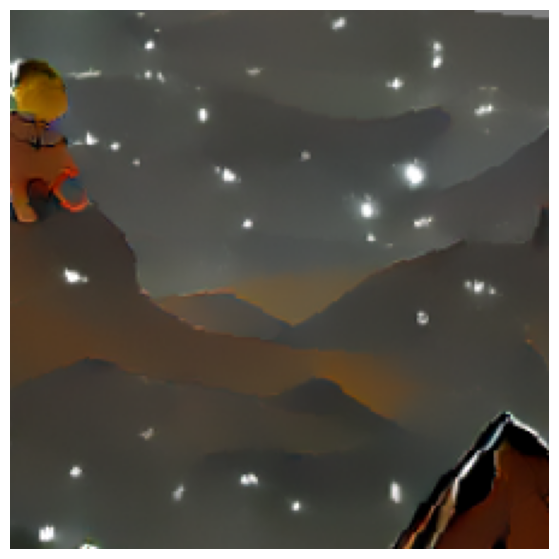

Generation


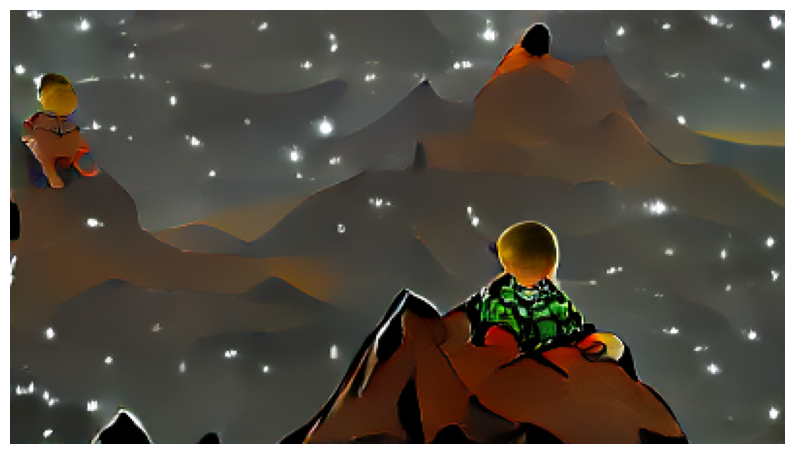

loss: -0.2294921875, 
iteration: 299


In [83]:
torch.cuda.empty_cache()

include=['boy on the top of the mountain looking at the stars']
exclude = 'watermark'
extras = ''
w1 = 1
w2 = 0.5

include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)

res_img, res_z = training_loop(Params, optimizer, show_crop=True)

In [84]:
def interpolate(res_z_list, duration_list):
  gen_img_list=[]
  fps = 25

  for idx, (z, duration) in enumerate(zip(res_z_list, duration_list)):
    num_steps = int(duration*fps)
    z1=z
    z2=res_z_list[(idx+1)%len(res_z_list)] # 1 x 256 x 14 x 25 (225/16, 400/16)

    for step in range(num_steps):
      alpha = math.sin(1.5*step/num_steps)**6
      z_new = alpha * z2 + (1-alpha) * z1

      new_gen=norm_data(generator(z_new).cpu())[0] ## 3 x 224 x 400
      new_img=T.ToPILImage(mode='RGB')(new_gen)
      gen_img_list.append(new_img)

  return gen_img_list

durations=[5,5,5,5,5,5]
interp_result_img_list = interpolate(res_z, durations)

In [85]:
## create a video
out_video_path=f"../video.mp4"
writer = imageio.get_writer(out_video_path, fps=25)
for pil_img in interp_result_img_list:
  img = np.array(pil_img, dtype=np.uint8)
  writer.append_data(img)

writer.close()

In [86]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('../video.mp4','rb').read()
data="data:video/mp4;base64,"+b64encode(mp4).decode()
HTML("""<video width=800 controls><source src="%s" type="video/mp4"></video>""" % data)